In [30]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms,datasets
import torchvision.models as models
import numpy as np
from math import floor
import torch.optim as optim
import warnings
warnings.filterwarnings('ignore')
from matplotlib import pyplot as plt


from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader

from tqdm import tqdm

## DATA

In [25]:
# Загрузка и подготовка данных
transform = transforms.Compose([
    # transforms.Resize(32),  # Увеличиваем размер изображений до 32x32
    # transforms.Grayscale(3),  # Преобразуем в 3 канала
    transforms.ToTensor(),
    # transforms.Normalize((0.5,), (0.5,))  # Нормализация для одного канала, дублируется для всех трех
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

## MODEL

In [26]:
class CNN(nn.Module):
    def __init__(self, k=1):
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=2),
            # nn.BatchNorm2d(6),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0),
            # nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.fc = nn.Linear(400, 120)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(120, 84)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.layer1(x)  #;print(x.shape)
        x = self.layer2(x) #;print(x.shape)
        x = x.reshape(x.size(0), -1)
        x = self.fc(x) #;print(x.shape)
        x = self.relu(x) #;print(x.shape)
        x = self.fc1(x) #;print(x.shape)
        x = self.relu1(x) #;print(x.shape)
        x = self.fc2(x) #;print(x.shape)
        return x

## TRAIN

In [31]:
# Обучение модели
def train_model(model, train_loader, criterion, optimizer, num_epochs=10, device='cpu'):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for images, labels in tqdm(train_loader):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f'Epoch {epoch+1}, Loss: {running_loss/len(train_loader)}')

In [34]:
def train_epoch(model, optimizer, train_loader, criterion, device):
    model.train()
    for it, traindata in enumerate(train_loader):
        train_inputs, train_labels = traindata
        train_inputs = train_inputs.to(device) 
        train_labels = train_labels.to(device)
        train_labels = torch.squeeze(train_labels)

        model.zero_grad()        
        output = model(train_inputs)
        loss = criterion(output, train_labels.long())
        loss.backward()
        optimizer.step()
def evaluate_loss_acc(loader, model, criterion, device):
    model.eval()
    total_acc = 0.0
    total_loss = 0.0
    total = 0.0
    for it, data in enumerate(loader):
        inputs, labels = data
        inputs = inputs.to(device) 
        labels = labels.to(device)
        labels = torch.squeeze(labels)

        output = model(inputs) # pay attention here!
        loss = criterion(output, labels.long())# + torch.norm(WW^T - I)
        total_loss += loss.item()
        pred = output.argmax(dim=1)
        correct = pred == labels.byte()
        total_acc += torch.sum(correct).item() / len(correct)

    total = it + 1
    return total_loss / total, total_acc / total

def train(model, opt, train_loader, test_loader, criterion, n_epochs, \
          device, verbose=True, prepare = None):
    train_log, train_acc_log = [], []
    val_log, val_acc_log = [], []

    for epoch in range(n_epochs):
        train_epoch(model, opt, train_loader, criterion, device, prepare = prepare)
        train_loss, train_acc = evaluate_loss_acc(train_loader,
                                                  model, criterion,
                                                  device)
        val_loss, val_acc = evaluate_loss_acc(test_loader, model,
                                              criterion, device)

        train_log.append(train_loss)
        train_acc_log.append(train_acc)

        val_log.append(val_loss)
        val_acc_log.append(val_acc)

        if verbose:
             print (('Epoch [%d/%d], Loss (train/test): %.4f/%.4f,'+\
               ' Acc (train/test): %.4f/%.4f' )
                   %(epoch+1, n_epochs, \
                     train_loss, val_loss, train_acc, val_acc))

    return train_log, train_acc_log, val_log, val_acc_log

In [37]:
model = CNN()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [38]:
num_epochs = 1

train_log, train_acc_log, val_log, val_acc_log =  train(train_loader=train_loader, test_loader=test_loader, model=model, criterion=criterion,opt=optimizer, device=device, n_epochs=num_epochs)
torch.save(model.state_dict(), './models/simple_cnn_mnist.pth')

Epoch [1/1], Loss (train/test): 0.0840/0.0759, Acc (train/test): 0.9742/0.9746


## LOAD CHECKPOINT

In [43]:
model = CNN()
model.load_state_dict(torch.load('./models/simple_cnn_mnist.pth'))
model.to(device)

CNN(
  (layer1): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=400, out_features=120, bias=True)
  (relu): ReLU()
  (fc1): Linear(in_features=120, out_features=84, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=84, out_features=10, bias=True)
)

## ATACKS

In [127]:
# FGSM attack code
def fgsm_attack(img, eps, data_grad):
    perturbed_img = img + eps*data_grad.sign() # Perturbing image by epsilon shift along element-wise sign of the data gradient
    perturbed_img = torch.clamp(perturbed_img, 0, 1) # As MNIST data must be in [0,1]
    return perturbed_img

In [ ]:
def evaluate_loss_acc(loader, model, criterion, device):
    model.eval()
    total_acc = 0.0
    total_loss = 0.0
    total = 0.0
    for it, data in enumerate(loader):
        inputs, labels = data
        inputs = inputs.to(device) 
        labels = labels.to(device)
        labels = torch.squeeze(labels)

        output = model(inputs) # pay attention here!
        loss = criterion(output, labels.long())# + torch.norm(WW^T - I)
        total_loss += loss.item()
        pred = output.argmax(dim=1)
        correct = pred == labels.byte()
        total_acc += torch.sum(correct).item() / len(correct)

    total = it + 1
    return total_loss / total, total_acc / total

In [115]:
def test( model, test_loader, eps ):
    real_acc = 0
    fake_acc = 0
    adv_examples = []


    for data, target in tqdm(test_loader):
        data.requires_grad = True 
        output = model(data)  
        init_pred = output.max(1, keepdim=True)[1].squeeze(-1)
        
        mask = init_pred == target

        real_acc += torch.sum(mask).item() / len(mask)

        loss = F.nll_loss(output, target) # Calculate the negative log likelihood loss
        model.zero_grad()
        loss.backward()

        data_grad = data.grad.data
        perturbed_data = fgsm_attack(data, eps, data_grad)
        output = model(perturbed_data)
        final_pred = output.max(1, keepdim=True)[1].squeeze(-1)
        
        correct = final_pred == target
        fake_acc += torch.sum(correct * mask ).item() / torch.sum(mask).item()
        adv_examples.append(( init_pred[0].item(), final_pred[0].item(), perturbed_data[0].squeeze().detach().numpy()))


    real_acc /= len(test_loader)
    fake_acc /= len(test_loader)

    print("Epsilon: {}\t Real Accuracy = {}, Fake Accuracy on the real true predictions = {}".format(eps, real_acc, fake_acc))

    return fake_acc , real_acc , adv_examples


In [116]:
epsilons = [0, .05, .1, .15, .2, .25, .3]

accuracies = []
examples = []

for eps in epsilons:
    fake_acc, real_acc, ex = test(model, test_loader, eps)
    accuracies.append(fake_acc)
    examples.append(ex)

100%|██████████| 157/157 [00:07<00:00, 20.77it/s]


Epsilon: 0	 Real Accuracy = 0.9746218152866242, Fake Accuracy on the real true predictions = 1.0


100%|██████████| 157/157 [00:07<00:00, 21.81it/s]


Epsilon: 0.05	 Real Accuracy = 0.9746218152866242, Fake Accuracy on the real true predictions = 0.9440500325662796


100%|██████████| 157/157 [00:06<00:00, 22.54it/s]


Epsilon: 0.1	 Real Accuracy = 0.9746218152866242, Fake Accuracy on the real true predictions = 0.8098413461870322


100%|██████████| 157/157 [00:06<00:00, 23.63it/s]


Epsilon: 0.15	 Real Accuracy = 0.9746218152866242, Fake Accuracy on the real true predictions = 0.5690430630045762


100%|██████████| 157/157 [00:07<00:00, 20.25it/s]


Epsilon: 0.2	 Real Accuracy = 0.9746218152866242, Fake Accuracy on the real true predictions = 0.29024102742578334


100%|██████████| 157/157 [00:07<00:00, 21.62it/s]


Epsilon: 0.25	 Real Accuracy = 0.9746218152866242, Fake Accuracy on the real true predictions = 0.10714449965544831


100%|██████████| 157/157 [00:07<00:00, 21.90it/s]

Epsilon: 0.3	 Real Accuracy = 0.9746218152866242, Fake Accuracy on the real true predictions = 0.029132516411001074


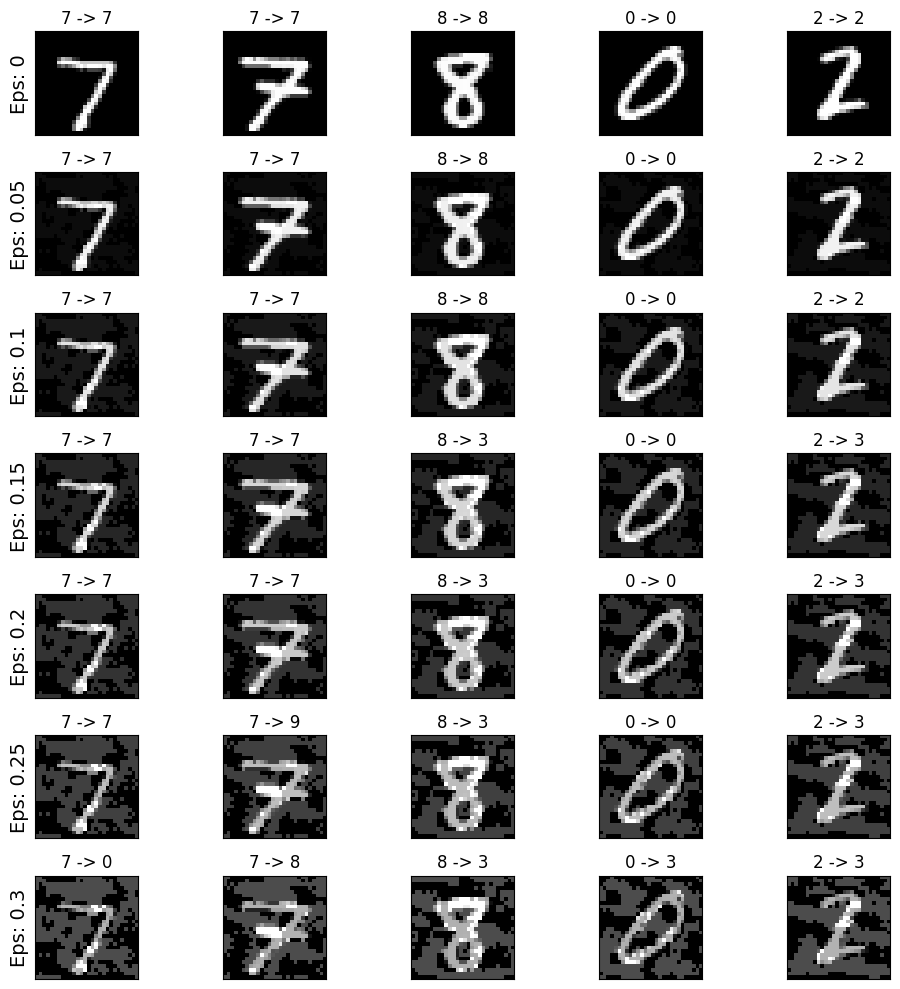

In [124]:

cnt = 0

cnt_ex = 5
plt.figure(figsize=(10,10))
for i in range(len(epsilons)):
    for j in range(min(len(examples[i]), cnt_ex)):
        cnt += 1
        plt.subplot(len(epsilons),min(len(examples[0]), cnt_ex),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
        orig,adv,ex = examples[i][j]
        plt.title("{} -> {}".format(orig, adv))
        plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()

Text(0, 0.5, 'Accuracy')

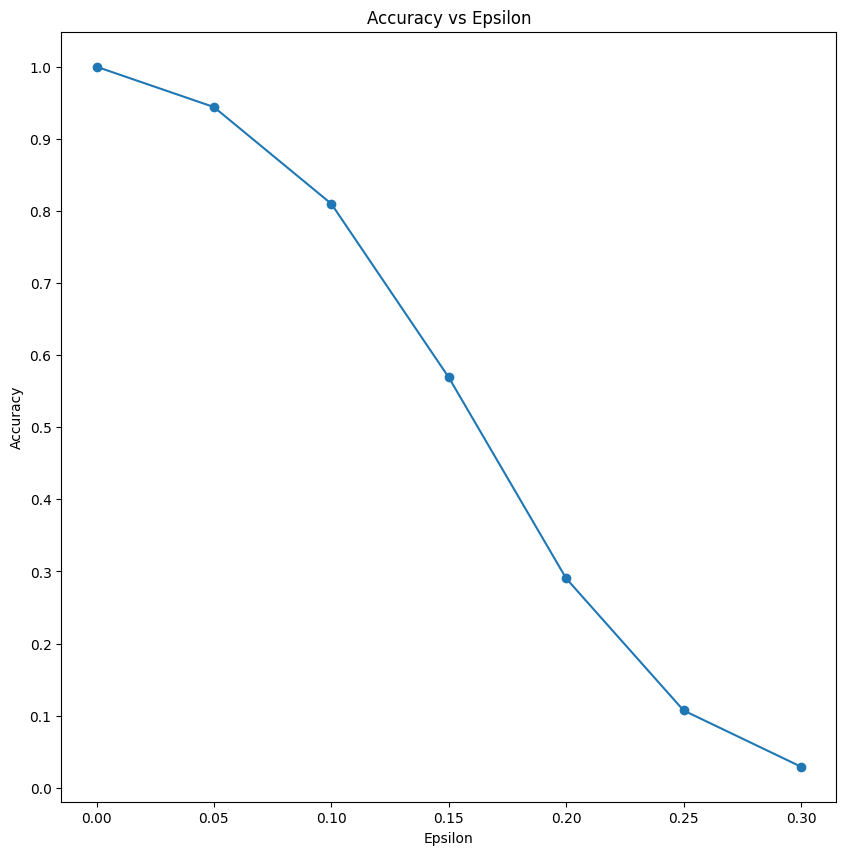

In [125]:
plt.figure(figsize=(10,10))
plt.plot(epsilons, accuracies,'-o')
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")

## AUGMENTATION FGSM

In [129]:
def fgsm_augment(data,target, model,eps ):
    output = model(data)  
    loss = F.nll_loss(output, target)
    model.zero_grad()
    loss.backward()
    data_grad = data.grad.data
    perturbed_data = fgsm_attack(data, eps, data_grad)
    return perturbed_data